In [1]:
cd /home/mffang/workspace/Poisson-regression

/home/mffang/workspace/Poisson-regression


In [2]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import RADOM
print(RADOM.__version__)

from RADOM.inference import Trajectory
from RADOM.mixtures import PoissonMixtureSS, PoissonMixture, GammaPoissonMixture
from RADOM.plotting import *

2023.09.01


In [3]:
from scipy.stats import spearmanr, pearsonr, entropy
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 

In [4]:
plt.rcParams['font.size'] = '24'
plt.rcParams['lines.linewidth'] = 12
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '30'
legend_font = '24'
title_font = '36'

In [5]:
import numpy.ma as ma

def plot_cor(A,B):
    a = ma.masked_invalid(A)
    b = ma.masked_invalid(B)
    msk = (~a.mask & ~b.mask)
    X = A[msk]
    Y = B[msk]
    plt.loglog(A[msk],A[msk],'#d8e9f2',zorder=0,linewidth=4)
    plt.scatter(A[msk],B[msk], color='#FF6F3C',\
           label="Pearson's r="+str(np.round(np.corrcoef(X,Y)[0,1],2))+", CCC="+str(np.round(CCC(X,Y),2))+", n="+str(np.sum(msk)));
    plt.legend(fontsize=legend_font)

# Load data

```
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom", "data/hgForebrainGlut.loom")
```

In [6]:
known_marker_genes=["SOX2","SLC17A7","EOMES"]
novel_marker_genes=["CLU","FBXO32","UNC5D","SEZ6","RBFOX1"]
their_genes=["DCX","GRIA3","STMN2", "FAM64A","ELAVL4","RNASEH2B"]
marker_genes = known_marker_genes + novel_marker_genes #+ their_genes

In [7]:
adata = sc.read('data/hgForebrainGlut.loom')
gene_names = adata.var_names
adata.var_names

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Index(['FAM138A', 'RP11-34P13.7', 'RP11-34P13.8', 'AL627309.1',
       'RP11-34P13.14', 'AP006222.2', 'RP4-669L17.2', 'RP5-857K21.1',
       'RP5-857K21.3', 'RP5-857K21.4',
       ...
       'BPY2', 'DAZ2', 'AC016752.1', 'TTTY17B', 'TTTY4B', 'BPY2B', 'DAZ4',
       'CSPG4P1Y', 'CDY1', 'TTTY3'],
      dtype='object', name='Gene', length=32738)

In [8]:
gene_length_file = np.loadtxt("data/gg_200525_genome_polyA_cum_3.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0].upper() for gene in gene_length_file])
print(np.sum(adata.var_names.isin(gene_name)))

20350


In [9]:
# Load an initial clustering (Louvein)
clusters = adata.obs["Clusters"]
Clusters = set(clusters)
print(Clusters)
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))

labels = clusters
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", colors20[:7], N=7)

{0, 1, 2, 3, 4, 5, 6}


In [10]:
clusters = adata.obs["Clusters"]
Clusters = set(clusters)
print(Clusters)

import matplotlib
cmap_cluster = matplotlib.cm.get_cmap('cividis')(np.linspace(0.1,0.9,7))
cell_colors = cmap_cluster[clusters]
cmap_cluster[[0, 1, 2, 3, 4, 5, 6]]*255

{0, 1, 2, 3, 4, 5, 6}


array([[  8.18805 ,  51.305745, 112.400175, 255.      ],
       [ 62.088675,  75.03987 , 107.86857 , 255.      ],
       [ 94.45965 ,  98.65695 , 110.52414 , 255.      ],
       [124.617735, 123.75609 , 120.10704 , 255.      ],
       [157.29726 , 149.407815, 117.870435, 255.      ],
       [191.98593 , 176.91033 , 106.20036 , 255.      ],
       [228.68859 , 206.81265 ,  81.85041 , 255.      ]])

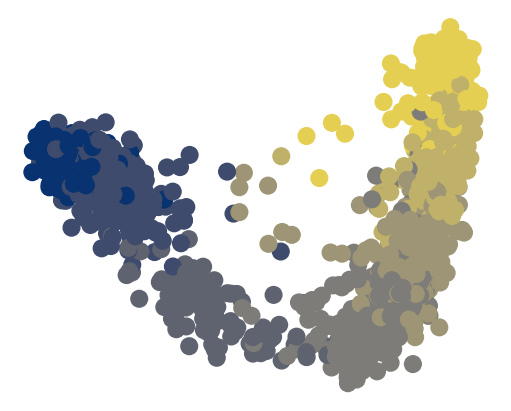

In [11]:
from sklearn.decomposition import PCA

total_UMI = adata.X.toarray().sum(axis=1)
r = total_UMI/np.mean(total_UMI)
pca = PCA(n_components=2)
x = pca.fit_transform(np.log(1+adata.X.toarray()/total_UMI[:,None]*np.mean(total_UMI)))

fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.scatter(-x[:,0],-x[:,1],c=cell_colors);
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

# Gene variance

0.07185885259573187 0.17890835555580814


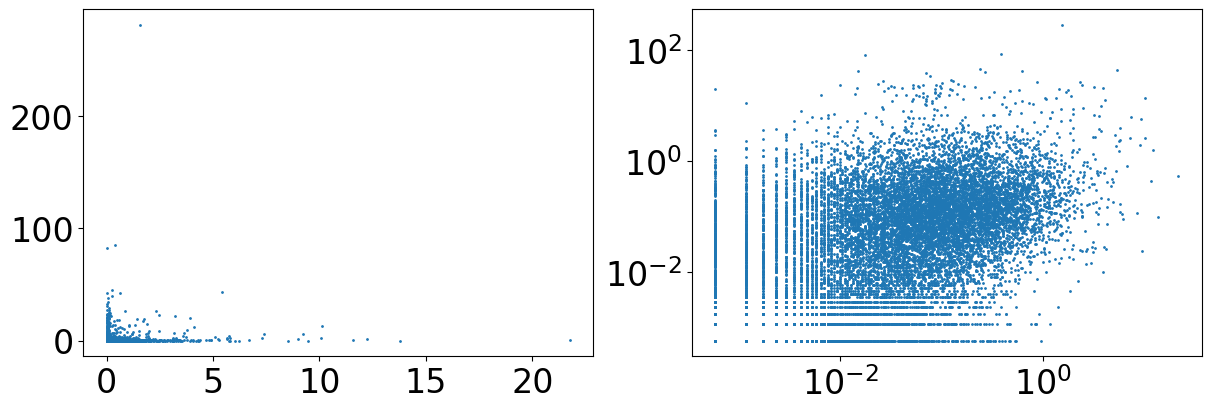

In [15]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

In [16]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0) & (adata.layers["unspliced"].toarray().mean(0) > 0)

U = adata.layers["unspliced"][:,idx].toarray()
n,p = U.shape
X = U
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
su = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total U counts =", str(su))

S = adata.layers["spliced"][:,idx].toarray()
n,p = S.shape
X = S
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
ss = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total S counts =", str(ss))

X = S + U
n,p = X.shape
X_cov = np.cov(X,rowvar=False)
X_mean = np.mean(X,axis=0)
X_rho = X_cov/X_mean[:,None]/X_mean[None,:]
s1 = (np.sum(X_rho)-np.sum(np.diag(X_rho)))/((p-1)*p)
print("s estimated by normalized covariance of total counts =", str(s1))

X_total = X.sum(1)
s2 = (X_total.var()-X_total.mean())/X_total.mean()**2
print("s estimated by total counts =", str(s2))

s estimated by normalized covariance of total U counts = 0.18500651291988127
s estimated by normalized covariance of total S counts = 0.18613105874418504
s estimated by normalized covariance of total counts = 0.16637448042385272
s estimated by total counts = 0.10577414939988984


In [17]:
a=1
sp=s1

X_bar = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
for i in range(5):
    Pgene_mask = (X_mean > 0.01) & (X_var/(a*X_mean + sp*X_mean**2) < 1.2)   
    P = (S + U)[:,Pgene_mask]
    n,p = P.shape
    P_cov = np.cov(P,rowvar=False)
    P_mean = np.mean(P,axis=0)
    P_rho = P_cov/P_mean[:,None]/P_mean[None,:]
    sp = (np.sum(P_rho)-np.sum(np.diag(P_rho)))/((p-1)*p)
    print(Pgene_mask.mean(),"s:", str(sp))

0.6198284211982842 s: 0.12329266236638191
0.5973432959734329 s: 0.1241459301613346
0.5978967759789677 s: 0.12412834710550452
0.5978275909782759 s: 0.12413503998122608
0.5978275909782759 s: 0.12413503998122608


Text(0.02, 0.5, 'CV$^2$')

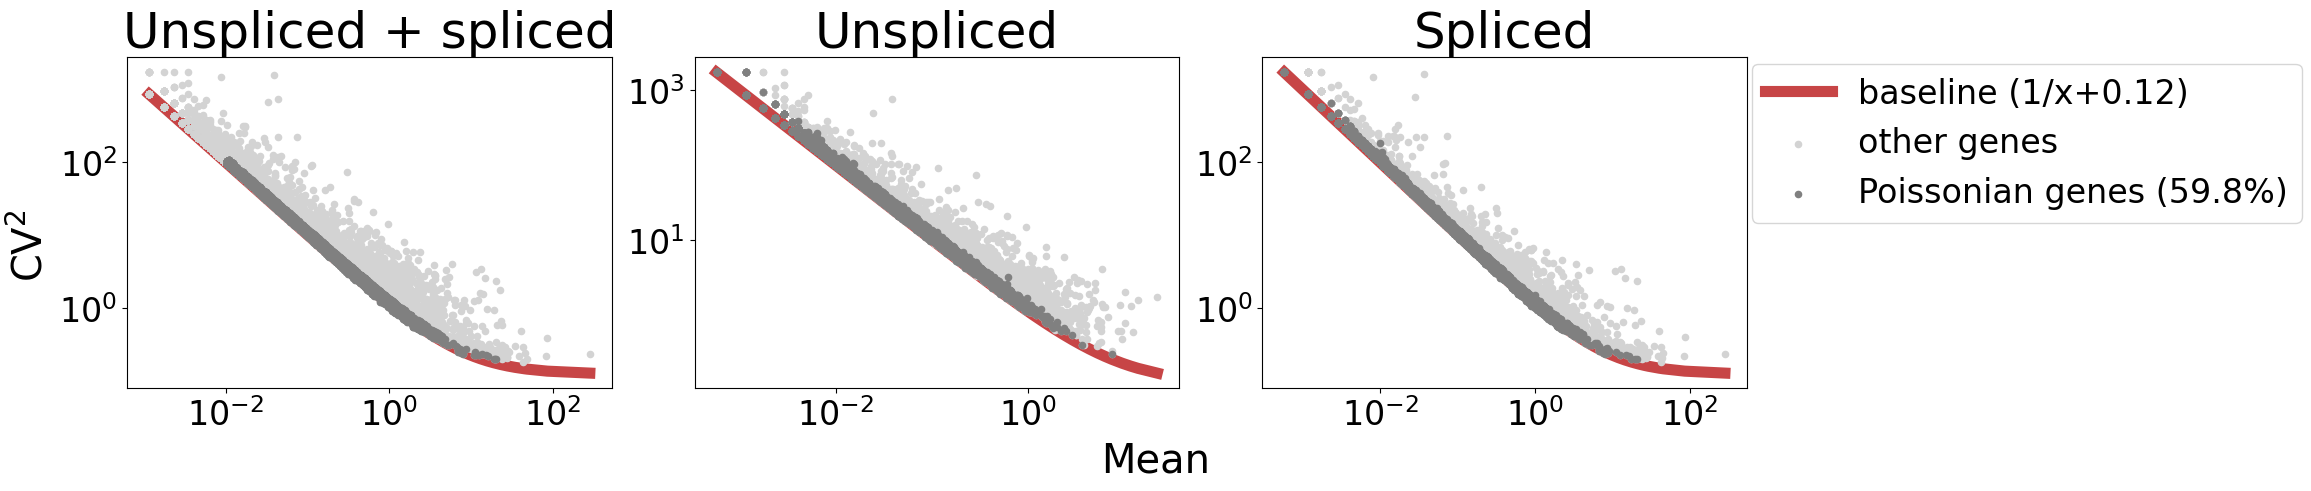

In [18]:
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

fig, ax = plt.subplots(1,3,figsize=(23,4.8))

ax[0].plot(np.sort(X_mean), a/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0)
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20)
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)

ax[1].plot(np.sort(U_mean), a/np.sort(U_mean) + sp, color='#c74546', linewidth=8, zorder=0)
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20, label='other genes')
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)

ax[2].plot(np.sort(S_mean), a/np.sort(S_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20, label='other genes')
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)

ax[2].legend(loc=(1.01,0.5),fontsize=legend_font)
fig.supxlabel('Mean')
fig.supylabel(r'CV$^2$')

Text(0, 0.5, 'Using total counts')

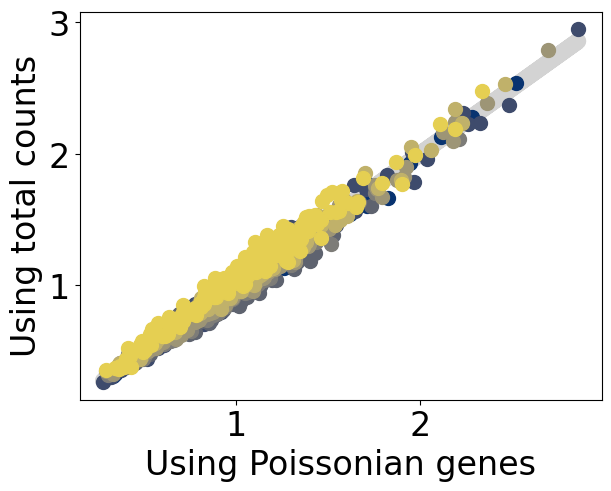

In [23]:
rd = (U + S)[:,Pgene_mask].mean(1)/(U + S)[:,Pgene_mask].mean()
rd_ = X_total/X_total.mean()
fig, ax = plt.subplots(1,1,figsize=(6,4.8))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    ax.scatter(rd[idx],rd_[idx],color=cmap_cluster[i],alpha=1,s=100,label=Cluster)
ax.plot(rd,rd,color='lightgray',zorder=0)
plt.xlabel('Using Poissonian genes',fontsize=legend_font)
plt.ylabel('Using total counts',fontsize=legend_font)
#plt.legend(loc=(1.01,0.3),fontsize=legend_font)

# Select genes

In [20]:
a=1
var_threshold = 1.5
U_mean = adata.layers["unspliced"].toarray().mean(0)
S_mean = adata.layers["spliced"].toarray().mean(0)
U_var = adata.layers["unspliced"].toarray().var(0)
S_var = adata.layers["spliced"].toarray().var(0)
fitted_idx = (U_mean > 0.02) & (S_mean > 0.1) \
    & (U_var/(a*U_mean + sp*U_mean**2) > var_threshold) \
    & (S_var/(a*S_mean + sp*S_mean**2) > var_threshold) \
    & (np.abs(np.log(S_mean/U_mean)) < 4)
fitted_genes=adata.var_names[fitted_idx]

/tmp/ipykernel_1362995/1583935953.py:8: RuntimeWarning: invalid value encountered in divide
  & (U_var/(a*U_mean + sp*U_mean**2) > var_threshold) \
/tmp/ipykernel_1362995/1583935953.py:9: RuntimeWarning: invalid value encountered in divide
  & (S_var/(a*S_mean + sp*S_mean**2) > var_threshold) \
/tmp/ipykernel_1362995/1583935953.py:10: RuntimeWarning: divide by zero encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_1362995/1583935953.py:10: RuntimeWarning: invalid value encountered in divide
  & (np.abs(np.log(S_mean/U_mean)) < 4)
/tmp/ipykernel_1362995/1583935953.py:10: RuntimeWarning: divide by zero encountered in log
  & (np.abs(np.log(S_mean/U_mean)) < 4)


In [21]:
cell_cycle_genes = np.loadtxt("data/cell_cycle_genes.txt",dtype="str")
fitted_genes = fitted_genes[~fitted_genes.isin(cell_cycle_genes)]
len(fitted_genes)

119

113


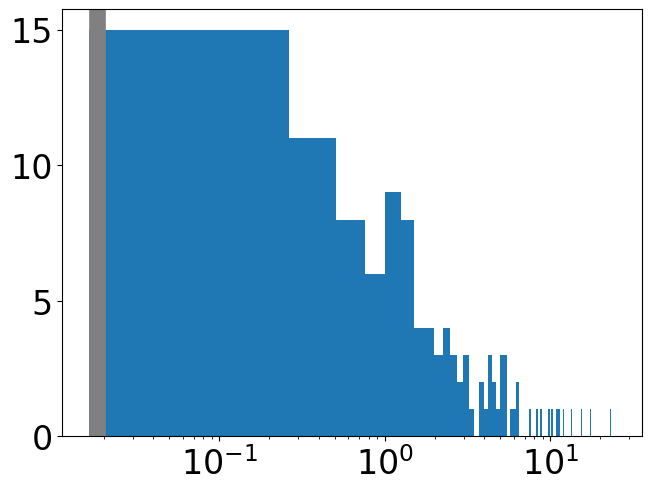

In [22]:
gene_length_file = np.loadtxt("data/gg_200525_genome_polyA_cum_3.txt",dtype="str")
gene_length = np.array([int(gene[1]) for gene in gene_length_file])
gene_name = np.array([gene[0] for gene in gene_length_file])

fitted_genes = fitted_genes[fitted_genes.isin(gene_name)]
fitted_idx = adata.var_names.isin(fitted_genes)
print(len(fitted_genes))

Ub_gene_idx = np.array([ np.where(gene_name == fitted_gene)[0][0]  for fitted_gene in fitted_genes ])
Ub = 10**(-5)*gene_length[Ub_gene_idx]
plt.hist(Ub,bins=100);
plt.xscale('log')
plt.axvline(x=np.e**(-4),color='gray');

1.6937024079028606 1.8610516567194897


/tmp/ipykernel_1362995/1367263143.py:3: RuntimeWarning: invalid value encountered in divide
  ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=10)
/tmp/ipykernel_1362995/1367263143.py:4: RuntimeWarning: divide by zero encountered in divide
  ax[0].scatter(S_mean, a/S_mean + sp, c='#c74546', alpha=0.5, s=20)
/tmp/ipykernel_1362995/1367263143.py:11: RuntimeWarning: invalid value encountered in divide
  ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=10, label='other genes')
/tmp/ipykernel_1362995/1367263143.py:12: RuntimeWarning: divide by zero encountered in divide
  ax[1].scatter(U_mean, a/U_mean + sp, c='#c74546', alpha=0.5, s=20, label='variance baseline')


(1720, 113, 2)

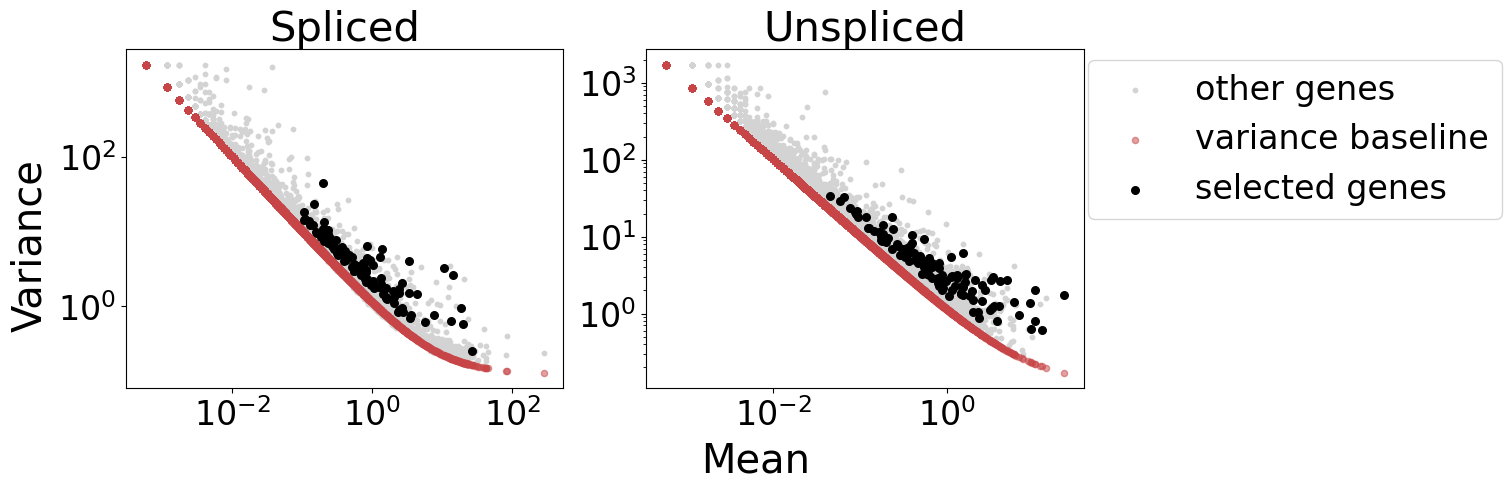

In [23]:
fig, ax = plt.subplots(1,2,figsize=(15,4.8))

ax[0].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=10)
ax[0].scatter(S_mean, a/S_mean + sp, c='#c74546', alpha=0.5, s=20)
ax[0].scatter(S_mean[fitted_idx], S_var[fitted_idx]/S_mean[fitted_idx]**2, s=30, c='k')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Spliced',fontsize=label_font)


ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=10, label='other genes')
ax[1].scatter(U_mean, a/U_mean + sp, c='#c74546', alpha=0.5, s=20, label='variance baseline')
ax[1].scatter(U_mean[fitted_idx], U_var[fitted_idx]/U_mean[fitted_idx]**2, s=30, c='k', label='selected genes')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(loc=(1.01,0.5),fontsize=legend_font)
ax[1].set_title('Unspliced',fontsize=label_font)
fig.supxlabel('Mean')
fig.supylabel('Variance')

X=np.zeros((adata.n_obs,fitted_idx.sum(),2))
X[:,:,0]=adata.layers["unspliced"][:,fitted_idx].toarray()
X[:,:,1]=adata.layers["spliced"][:,fitted_idx].toarray()
fitted_genes=adata.var_names[fitted_idx]
print(X[:,:,0].mean(),X[:,:,1].mean())
X.shape

In [24]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in marker_genes]
plot_idx = np.concatenate(plot_idx).ravel()
if plot_idx.sum() == 0:
    plot_idx = np.arange(10)
else:
    print(fitted_genes[plot_idx])

Index(['CLU', 'FBXO32', 'RBFOX1'], dtype='object', name='Gene')


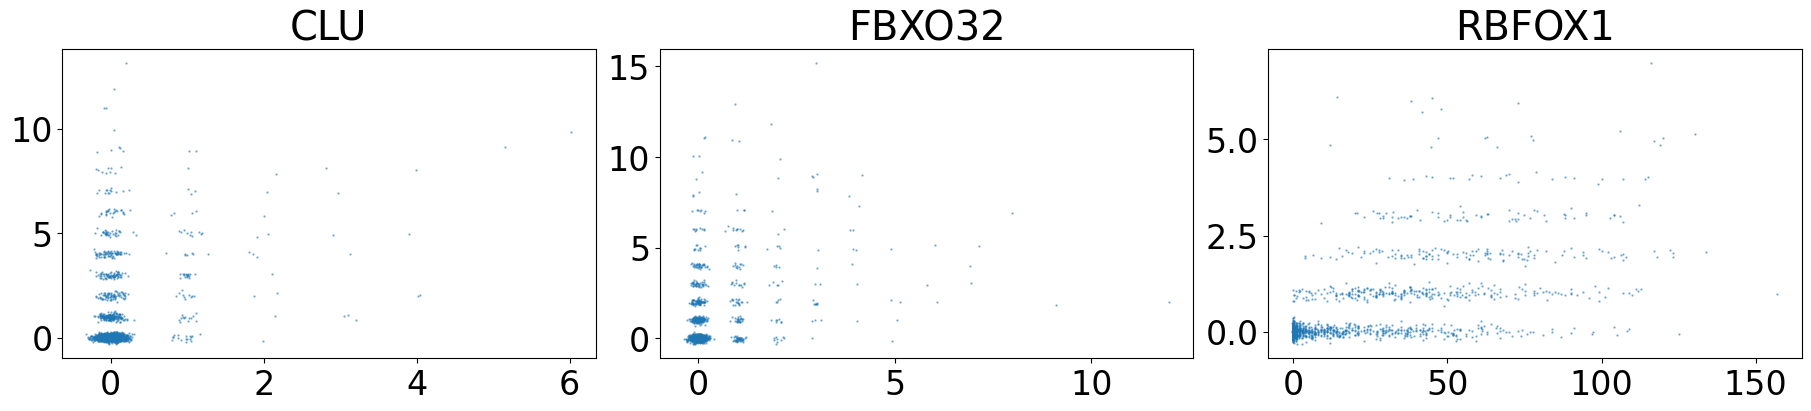

In [25]:
pp = min(10,len(plot_idx))
fix, ax = plt.subplots(1,pp,figsize=(6*pp,4))
for i in range(pp):
    j = plot_idx[i]
    ax[i].set_title(fitted_genes[j])
    ax[i].scatter(X[:,j,0]+np.random.normal(0,0.1,X.shape[0]),X[:,j,1]+np.random.normal(0,0.1,X.shape[0]),s=0.5,alpha=0.5) #,c=adata.obs['louvain'])

# Mixtures fitting

In [26]:
cell_idx = clusters.isin(Clusters)
X_mix = X[cell_idx]

1 -401.04738769498937 -401.17878304382657 -401.5368405969593
2 -306.52999847971836 -306.727672898323 -307.2663435534784
3 -286.2611955922675 -286.52514908063955 -287.24443283781767
4 -278.30663034273795 -278.6368629008775 -279.53675976007827
5 -275.7109990228214 -276.1075106507284 -277.18802061195186
6 -271.41384542475856 -271.87663612243296 -273.13775918567916


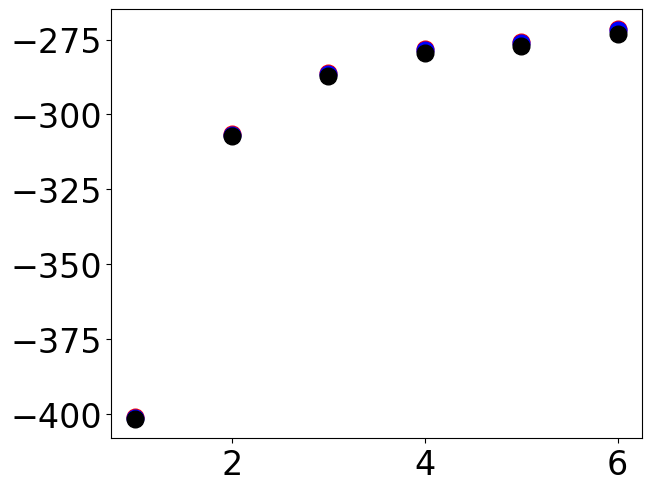

In [27]:
PMs = []
for nc in range(1,7):
    PM = PoissonMixtureSS(n_components=nc,verbose=0)
    Q, elbo = PM.fit(X_mix,warm_start=False,read_depth=rd,epoch=5,n_init=3)
    PMs.append(PM)
    plt.scatter(nc,elbo,color='r')
    plt.scatter(nc,PM.compute_AIC(X_mix),color='b')
    plt.scatter(nc,PM.compute_BIC(X_mix),color='k')
    print(nc,PM.compute_lower_bound(X_mix),PM.compute_AIC(X_mix),PM.compute_BIC(X_mix))

In [44]:
PM = PoissonMixtureSS(n_components=3,verbose=0)
Q, elbo = PM.fit(X,warm_start=False,read_depth=rd,epoch=10,n_init=10)
PM.Q = Q
PM.elbo = elbo
PM.weights

array([0.25768075, 0.34747792, 0.39484133])

(-286.1317566348798, array([0.25768075, 0.34747792, 0.39484133]))

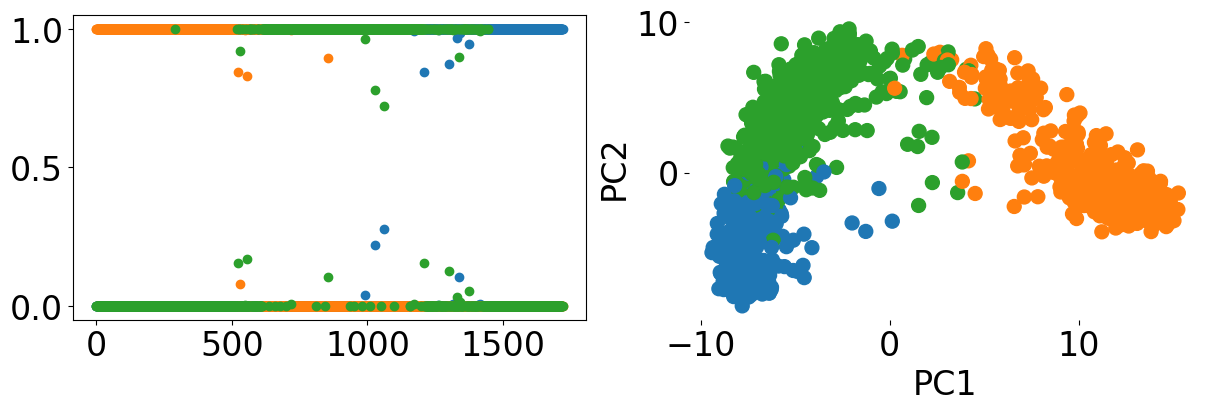

In [47]:
tab_colors = plt.cm.tab10(np.arange(10))
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(Q[np.argsort(clusters)],'.');
ax[1].scatter(x[:,0],x[:,1],c=tab_colors[np.argmax(Q,axis=-1)],s=100);
ax[1].set_xlabel('PC1',fontsize=24)
ax[1].set_ylabel('PC2',fontsize=24)
ax[1].set_frame_on(False)

elbo, PM.weights

# Trajectory fitting

In [27]:
elbos = {}
traj_params={'r':rd,"lambda_tau":0,"lambda_a":0}

In [30]:
with open('results/Forebrain.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    data = pickle.load(f)
    
trajs = data['ri']
traj_ws = data['ws']
rd = traj_ws.params['r']
X = traj_ws.X.copy()

## Warm start

In [28]:
m=100
weight0 = np.zeros((adata.n_obs,m))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    weight0[idx,int(i*m/len(Clusters)):int((i+1)*m/len(Clusters))] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]

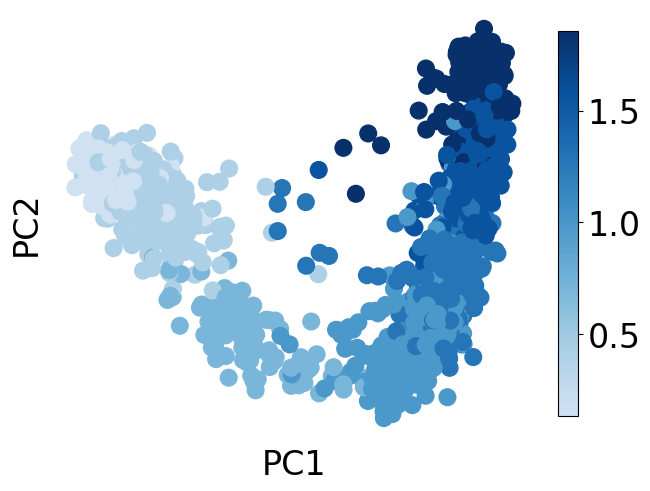

In [32]:
t_hat = Q0.sum(1)@np.linspace(0,2,m)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(-x[:,0],-x[:,1],c=t_hat,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [33]:
topo = np.array([[0,1,2]])
tau = (0,1,2) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,warm_start=True,fit_tau=True,params=traj_params,Q=Q0,parallel=True,n_threads=4,epoch=100)
print(traj.elbos[-1])
traj_ws = copy.deepcopy(traj)

Reminder: provide genewise unspliced to spliced capture rate ratio in params with key Ub
fitting with warm start


100%|██████████| 100/100 [01:48<00:00,  1.08s/it]

-274.53877401624436


In [34]:
topo = np.array([[0,1,2]])
tau = (0,1,2) # ~48 hours
traj_ws_Ub = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj_ws_Ub = traj_ws_Ub.fit(X,warm_start=True,fit_tau=True,params=traj_params_Ub,Q=Q0,parallel=True,n_threads=4,epoch=100)
print(traj_ws_Ub.elbos[-1])

fitting with warm start


100%|██████████| 100/100 [01:54<00:00,  1.14s/it]

-277.2914440446562


In [111]:
traj = copy.deepcopy(traj_ws)

[0.        1.3604131 2.       ]


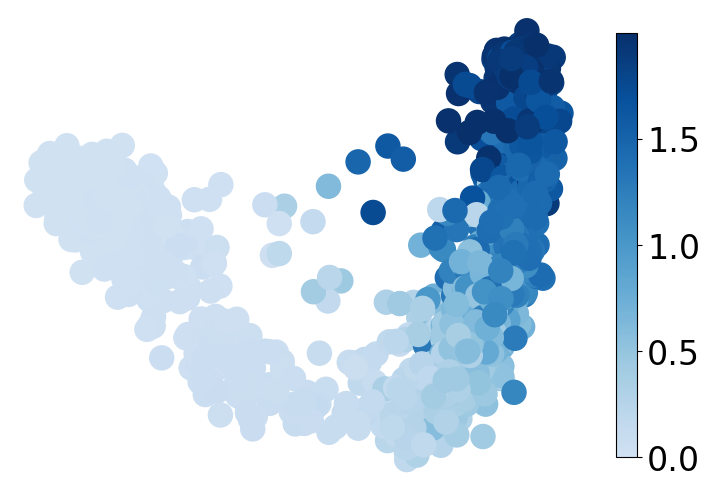

In [93]:
print(traj.tau)
t_hat = traj.Q.sum(1)@traj.t
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)

fig, ax = plt.subplots(1,1,figsize=(7,4.8))
im=ax.scatter(-x[:,0],-x[:,1],c=t_hat,cmap=cmap_y,s=300);
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

[]

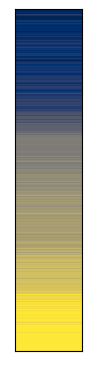

In [94]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i

fig, ax = plt.subplots(1,1,figsize=(0.8,3.55))
ax.imshow(cluster[order,None],aspect="auto",cmap="cividis")
ax.set_xticks([])
ax.set_yticks([])

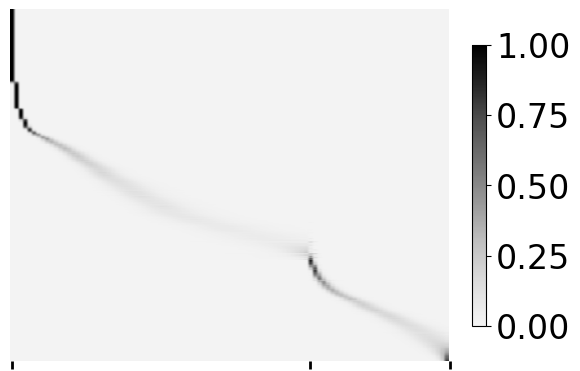

In [95]:
fig, ax = plt.subplots(1,1,figsize=(5.7,3.6))
cmap_Q = cmr.get_sub_cmap('Greys', 0.1, 1)

im = ax.imshow(traj.Q.sum(1)[order],aspect="auto",cmap=cmap_Q);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = []#[r'$\hat{\tau}_0$', r'$\hat{\tau}_1$', r'$\hat{\tau}_2$']
ax.tick_params(direction='out', length=6, width=2)
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

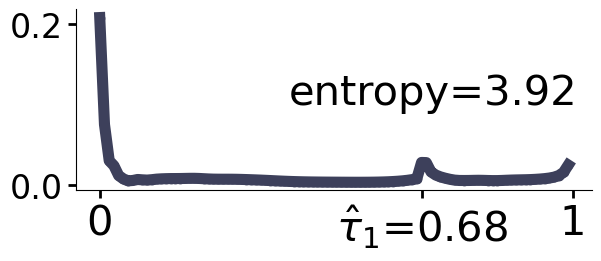

In [112]:
fig,ax = plt.subplots(figsize=(5.9,2.5))
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=8);
x_label_list = ['0', r'$\hat{\tau}_1$='+str(np.around(traj.tau[1]/traj.tau[-1],2)), '1']
ax.tick_params(direction='out', length=6, width=2)
ax.set_xticks(traj.m*traj.tau/traj.tau[-1])
ax.set_xticklabels(x_label_list,fontsize=30)
ax.text(40,0.1,"entropy="+str(np.around(entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)),fontsize=label_font)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

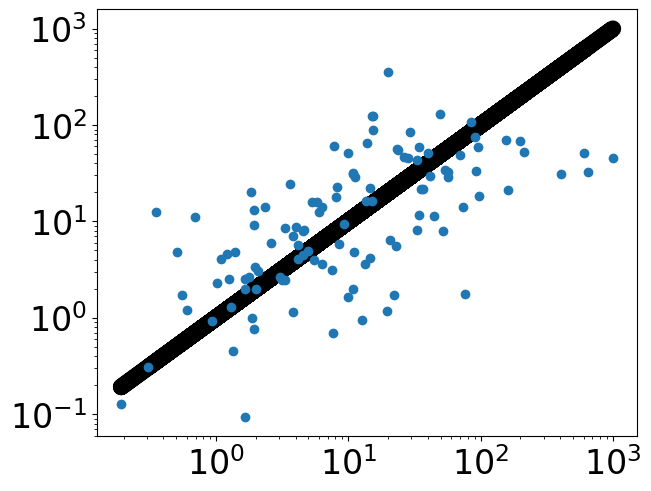

In [113]:
plt.loglog(traj.theta[:,-2],traj.theta[:,-2],'k');
plt.loglog(traj.theta[:,-2],traj.theta[:,-1],'.');

47.0044253237874 25.776597913093116


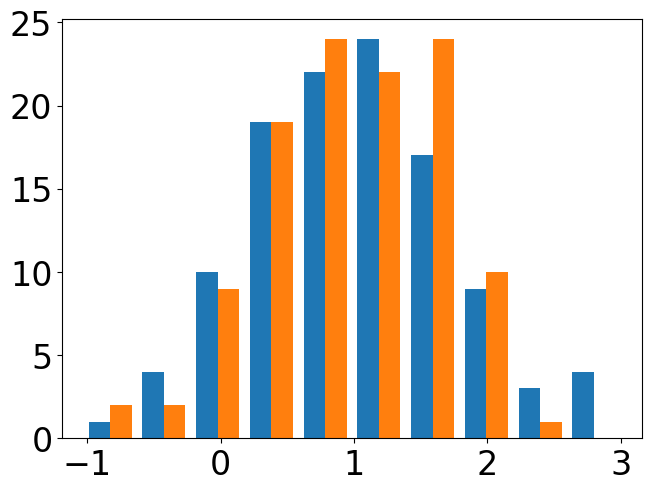

In [114]:
plt.hist([np.log10(traj.theta[:,-2]),np.log10(traj.theta[:,-1])],bins=10)
print(traj.theta[:,-2].mean(),traj.theta[:,-1].mean())

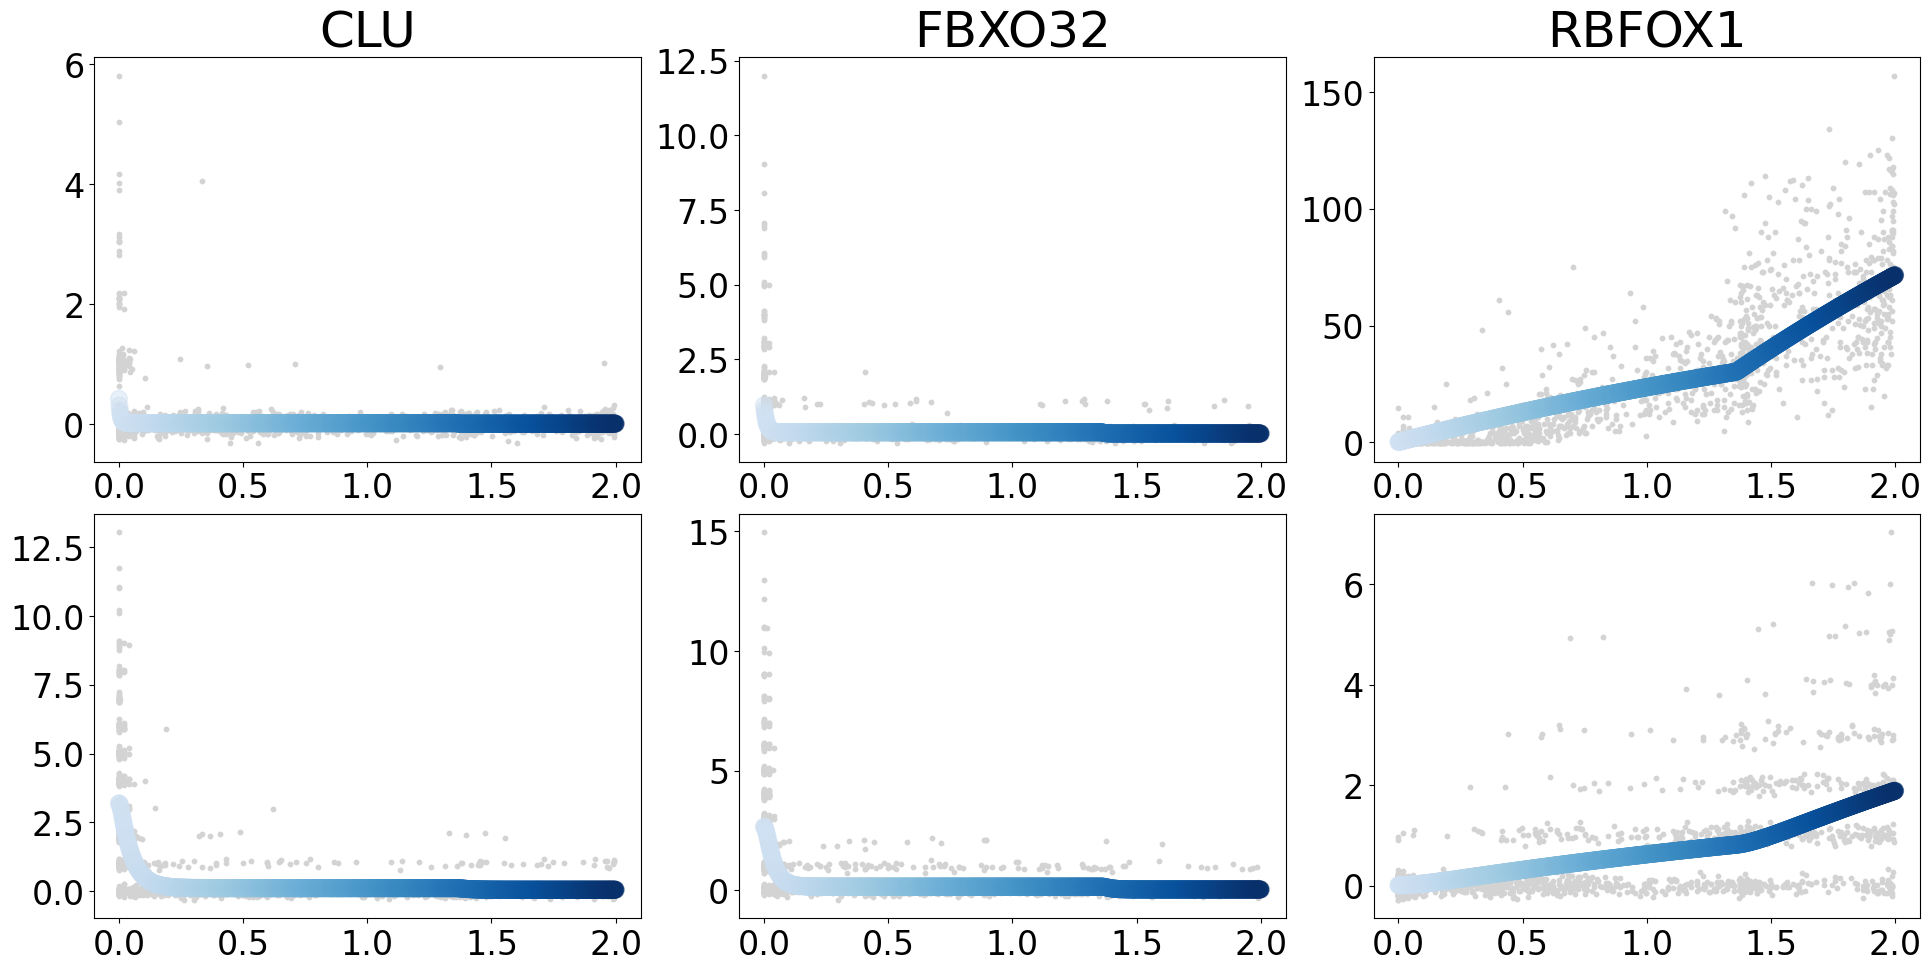

In [115]:
plot_y(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

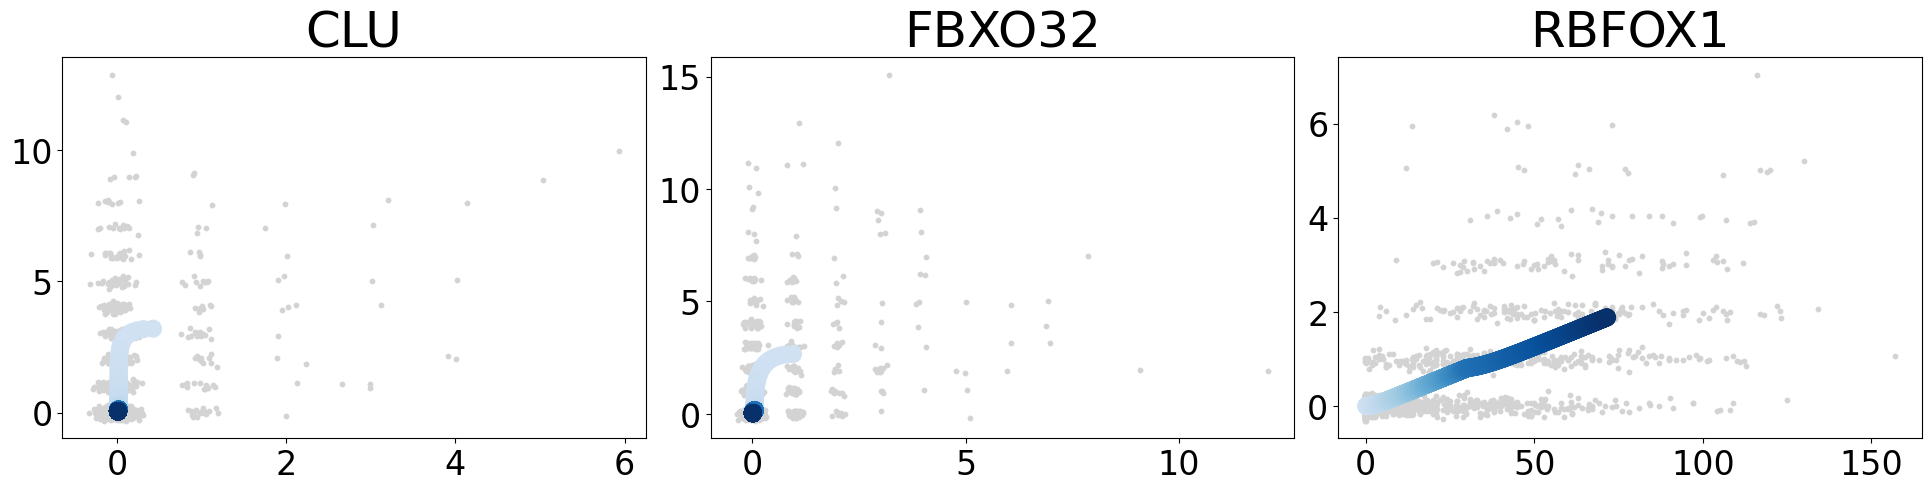

In [116]:
plot_phase(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

In [47]:
plot_marker_genes = known_marker_genes

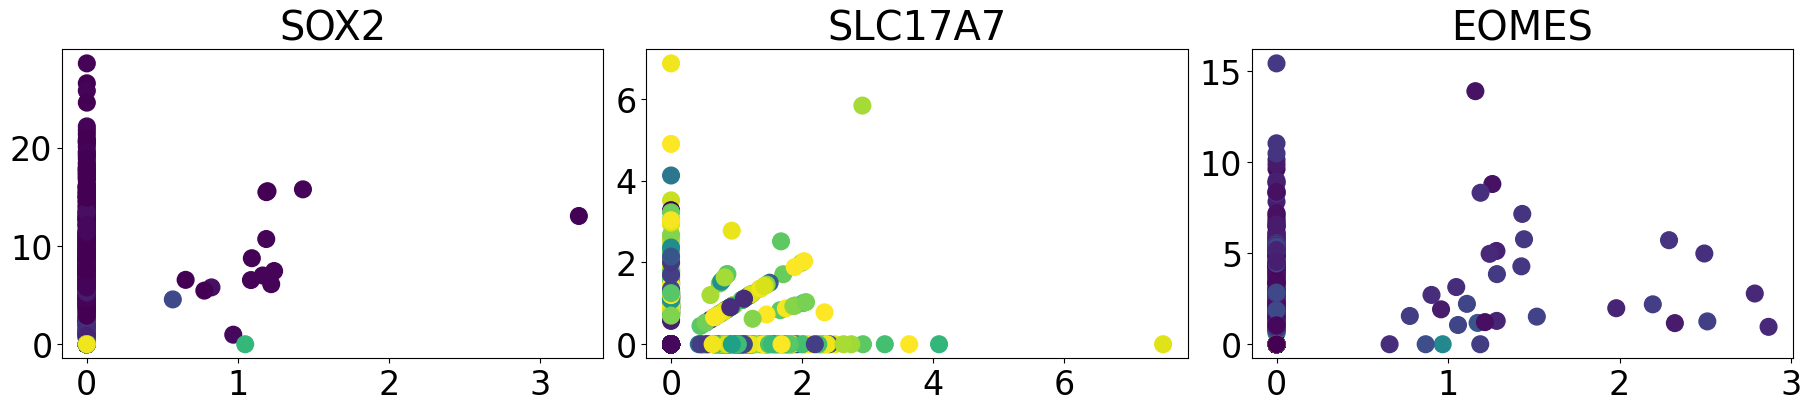

In [48]:
fig,ax = plt.subplots(1,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),4))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[i].set_title(gene)
    ax[i].scatter(adata.layers["unspliced"].toarray()[:,j]/rd,adata.layers["spliced"].toarray()[:,j]/rd,c=traj.Q[:,0]@traj.t)

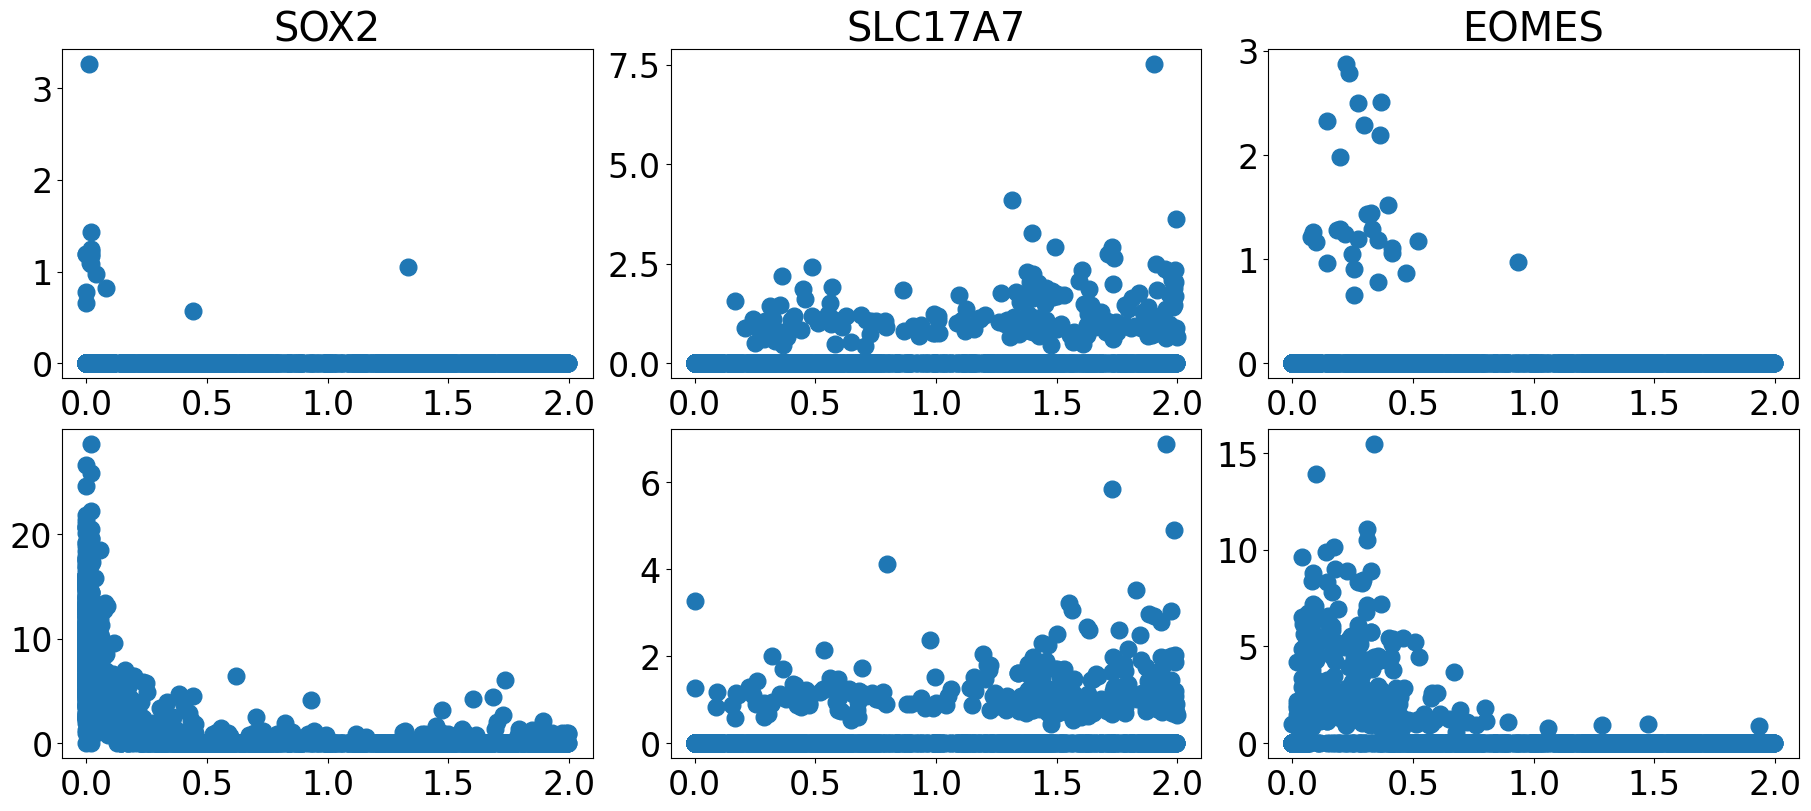

In [49]:
fig,ax = plt.subplots(2,len(plot_marker_genes),figsize=(6*len(plot_marker_genes),8))
for i,gene in enumerate(plot_marker_genes):
    j = np.where(adata.var_names == gene)[0][0]
    ax[0,i].set_title(gene)
    ax[0,i].scatter(traj.Q[:,0]@traj.t,adata.layers["unspliced"].toarray()[:,j]/rd)
    ax[1,i].scatter(traj.Q[:,0]@traj.t,adata.layers["spliced"].toarray()[:,j]/rd)

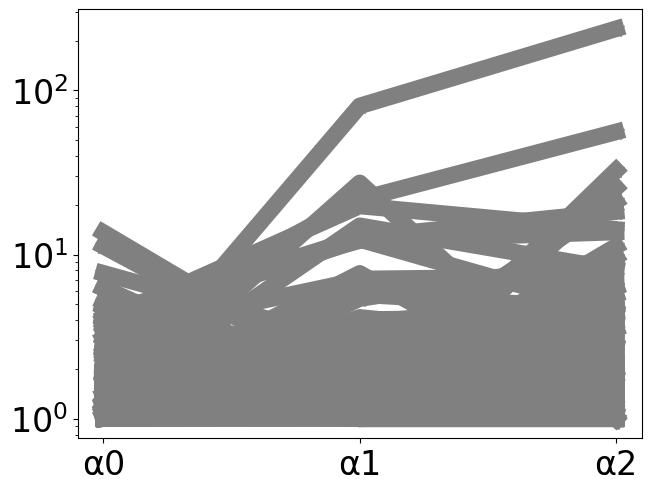

In [50]:
p=traj.theta.shape[0]
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(1+traj.theta[j,[0,1,2]],'-*',color='gray')
x_label_list = ['α0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
plt.yscale('log')

In [51]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Random initializations

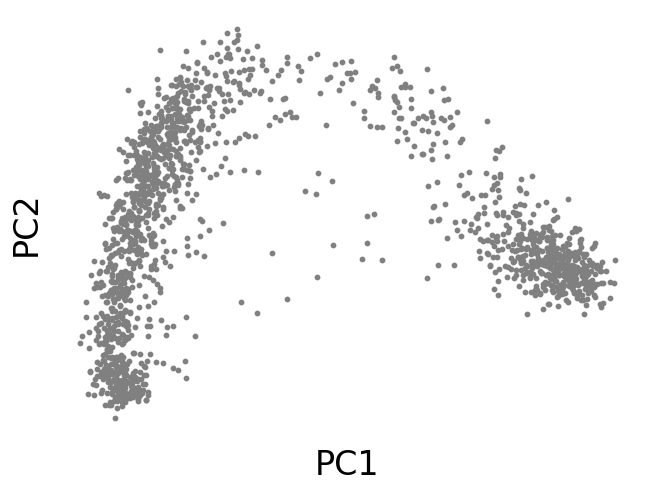

In [52]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

### two_species_ss

In [53]:
from multiprocessing import Pool

tau = (0,1,2)
topo = np.array([[0,1,2]])
Input_args = []
def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,params=traj_params,perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
with Pool(25) as pool:      
    trajs = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [45]:
data = {'ri':trajs,'ws':traj_ws,'PM':PM}

In [46]:
with open('results/Forebrain.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [36]:
corrs = []
AICs = []
right_t = Q0[:,0] @ trajs[0].t
for traj in trajs:
    t_hat = traj.Q[:,0] @ traj.t
    corrs.append(pearsonr(right_t,t_hat)[0])
    AICs.append( traj.compute_AIC(traj.X, standard=True) )

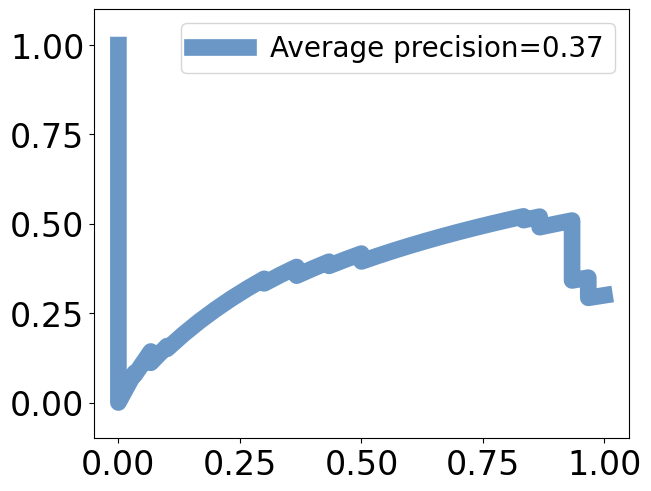

In [41]:
from sklearn.metrics import average_precision_score, precision_recall_curve

is_correct_direction = np.array(np.array(corrs)>0.8,dtype=bool)
corrs_ratio = np.mean(is_correct_direction)
precision, recall, thresholds = precision_recall_curve(y_true=is_correct_direction,probas_pred=-np.array(AICs))
score = average_precision_score(y_true=is_correct_direction, y_score=-np.array(AICs))
plt.plot(recall, precision,'-',color='#3975b5',alpha=0.75,label="Average precision="+str(np.around(score,2)))
plt.ylim([-0.1,1.1])
plt.legend(fontsize=20)

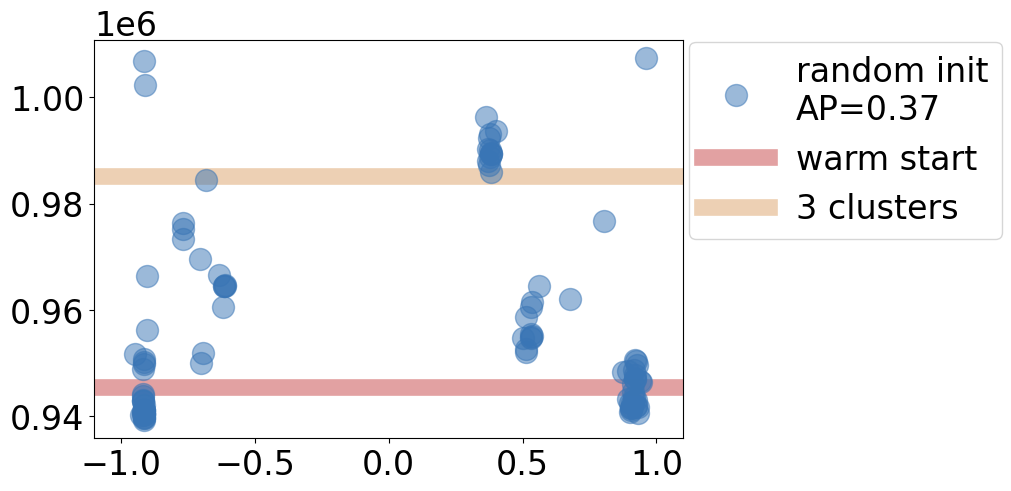

In [48]:
fig, ax = plt.subplots(1,1,figsize=(10,4.8))
plt.scatter(corrs,np.array(AICs),s=1000,marker='.',color='#3975b5',alpha=0.5,label='random init\nAP='+str(np.around(score,2)))
plt.axhline(traj_ws.compute_AIC(traj.X, standard=True),linewidth=12,zorder=0,color='#c74546',alpha=0.5,label='warm start')
plt.axhline(PM.compute_AIC(traj.X, standard=True),color='#dca36a',linewidth=12,zorder=0,alpha=0.5,label='3 clusters')
#ax.set_yticks([])
ax.set_xlim([-1.1,1.1])
plt.legend(loc=(1.01,0.5),fontsize=legend_font)
#plt.title('ELBO of different initialiazations',fontsize=30)

In [58]:
idx = np.arange(100)[:][np.argmax(elbos[correct])]
traj = trajs[idx]
traj.elbos[-1][-1]

-273.792073500955

[0.         1.30061112 2.        ]


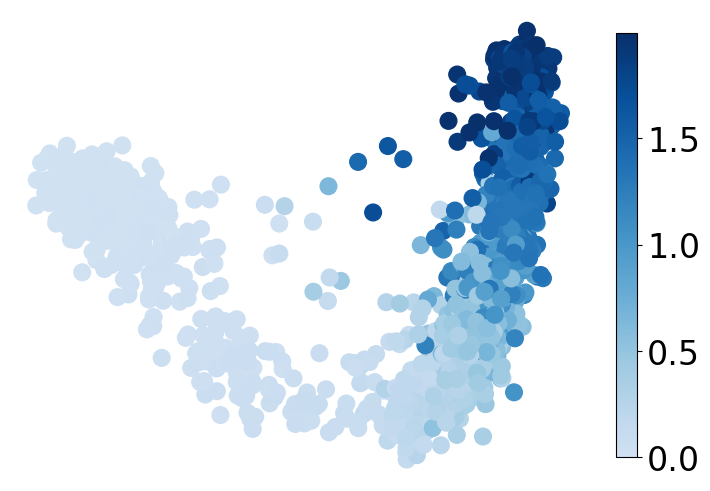

In [59]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1,figsize=(7,4.8))
im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [60]:
idx = np.arange(100)[correct][np.argmax(elbos[correct])]
traj = trajs[idx]
traj.elbos[-1][-1]

-273.09041615674

[0.         0.97823058 2.        ]


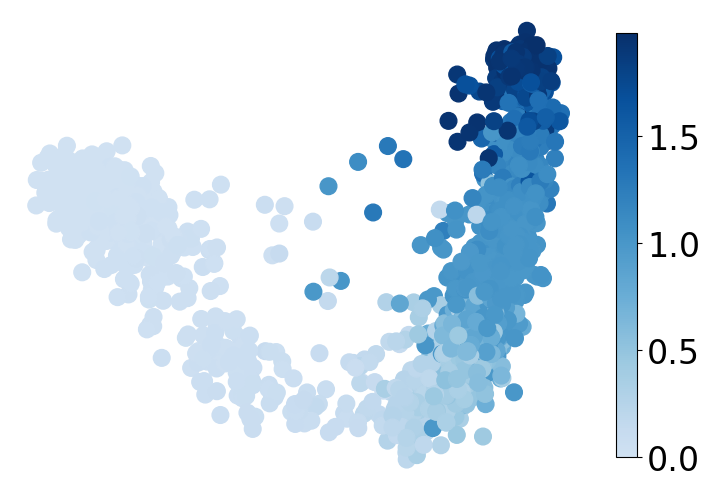

In [61]:
print(traj.tau)
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1,figsize=(7,4.8))
im=ax.scatter(-x[:,0],-x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

0.10251031236430891
0.9145310017225362 2.240249626822131


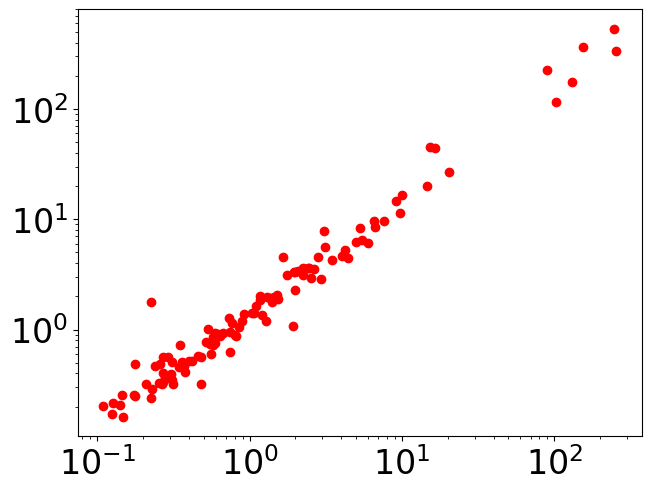

In [62]:
Y = traj.get_Y_hat(traj.theta, t_hat, traj.tau, traj.topo, traj.params)[0]
rd_s = traj.params['r'].var()/traj.params['r'].mean()**2
print(rd_s)
mean = X[:,:,1].mean(axis=0)
var = X[:,:,1].var(axis=0)
Y_mean = Y[:,:,1].mean(axis=0)
Y_var = Y[:,:,1].var(axis=0)
plt.loglog(rd_s*mean**2+mean+(1+rd_s)*Y_var,var,'r.')
signal = Y_var
noise = var-rd_s*mean**2-(1+rd_s)*Y_var
unexplained = noise - mean
print((signal/mean).mean(),(noise/mean).mean())

[]

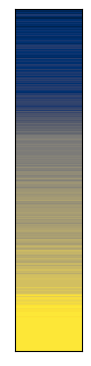

In [63]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(adata.n_obs)
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    cluster[idx] = i

fig, ax = plt.subplots(1,1,figsize=(0.8,3.55))
ax.imshow(cluster[order,None],aspect="auto",cmap="cividis")
ax.set_xticks([])
ax.set_yticks([])

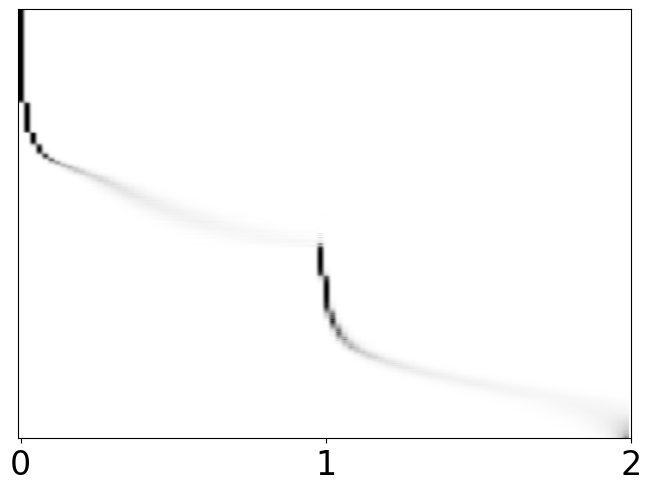

In [64]:
ax = plot_t(traj,l=0,order_cells=True)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

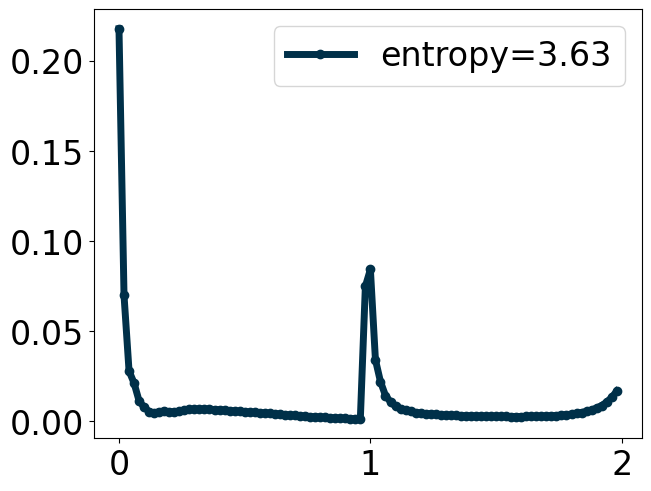

In [65]:
ax = plt.subplot()
ax.plot(traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#003049",linewidth=5,\
        label="entropy="+str(np.around(entropy(traj.Q.sum((0,1))/traj.Q.sum()),2)));
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list)
ax.legend()

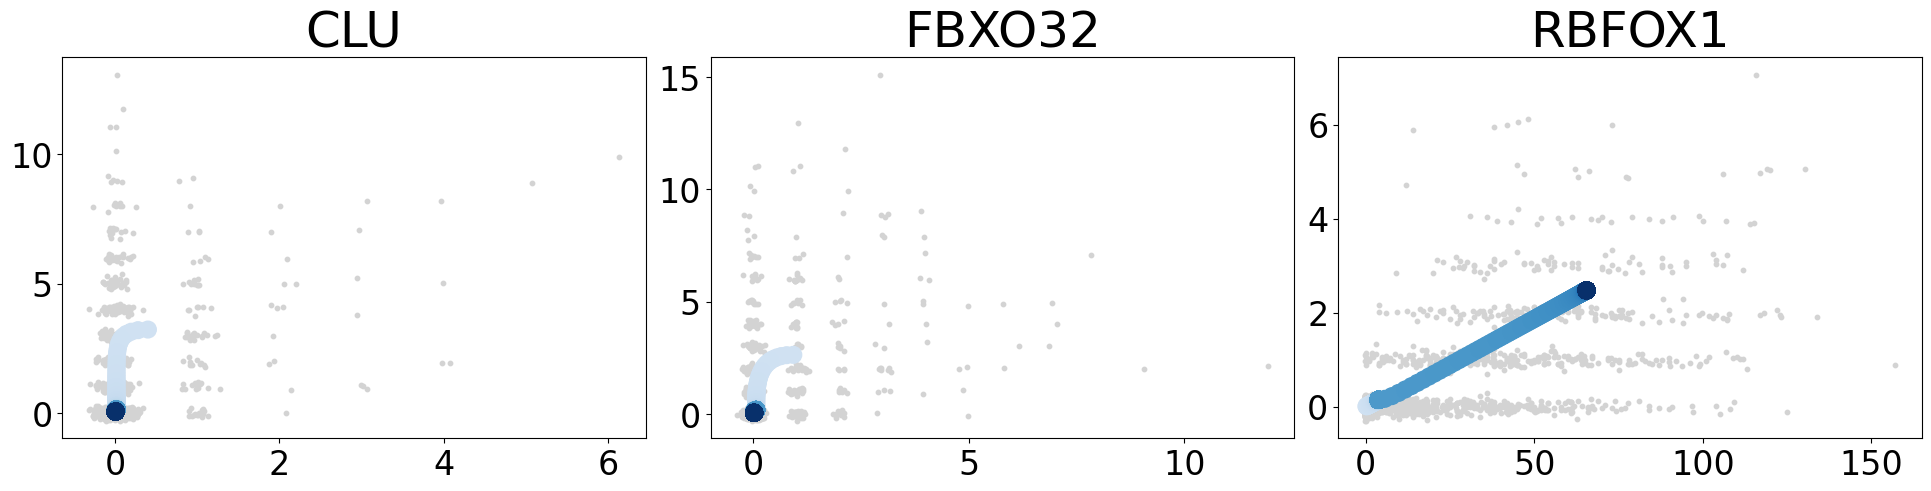

In [66]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes);

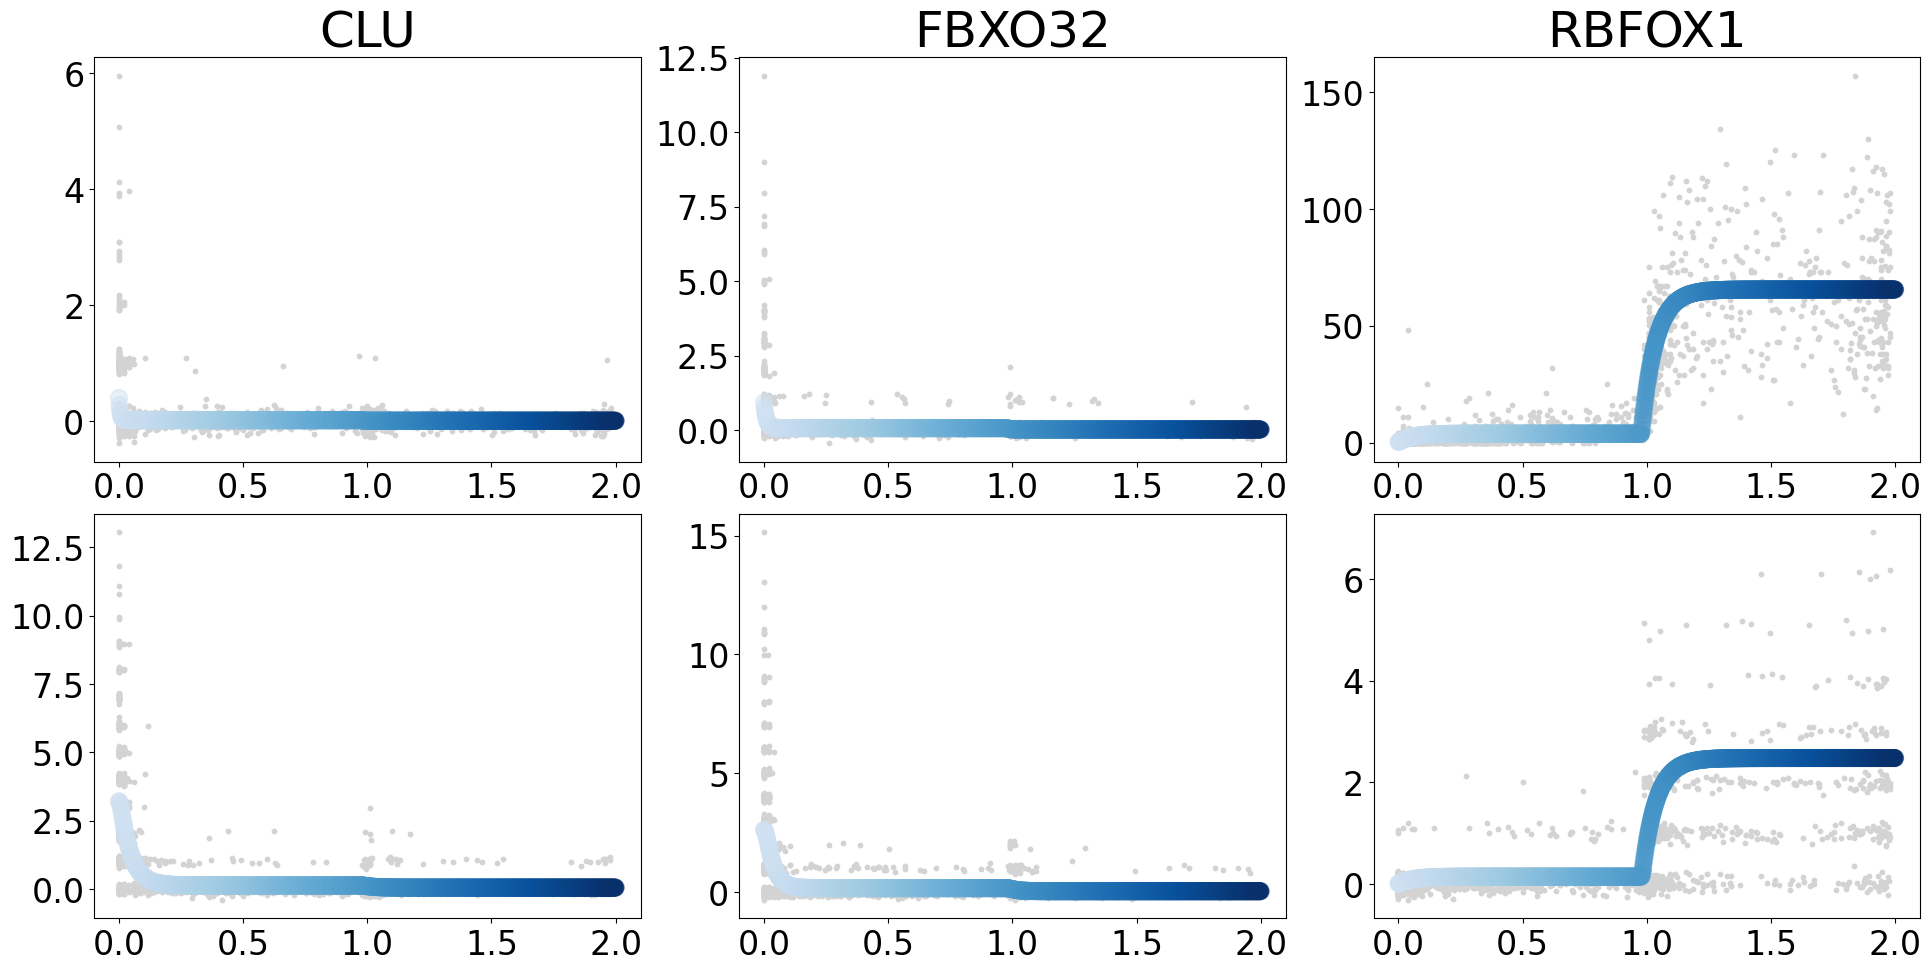

In [67]:
plot_y(traj,X=X,idx=plot_idx,gene_name=fitted_genes);

11


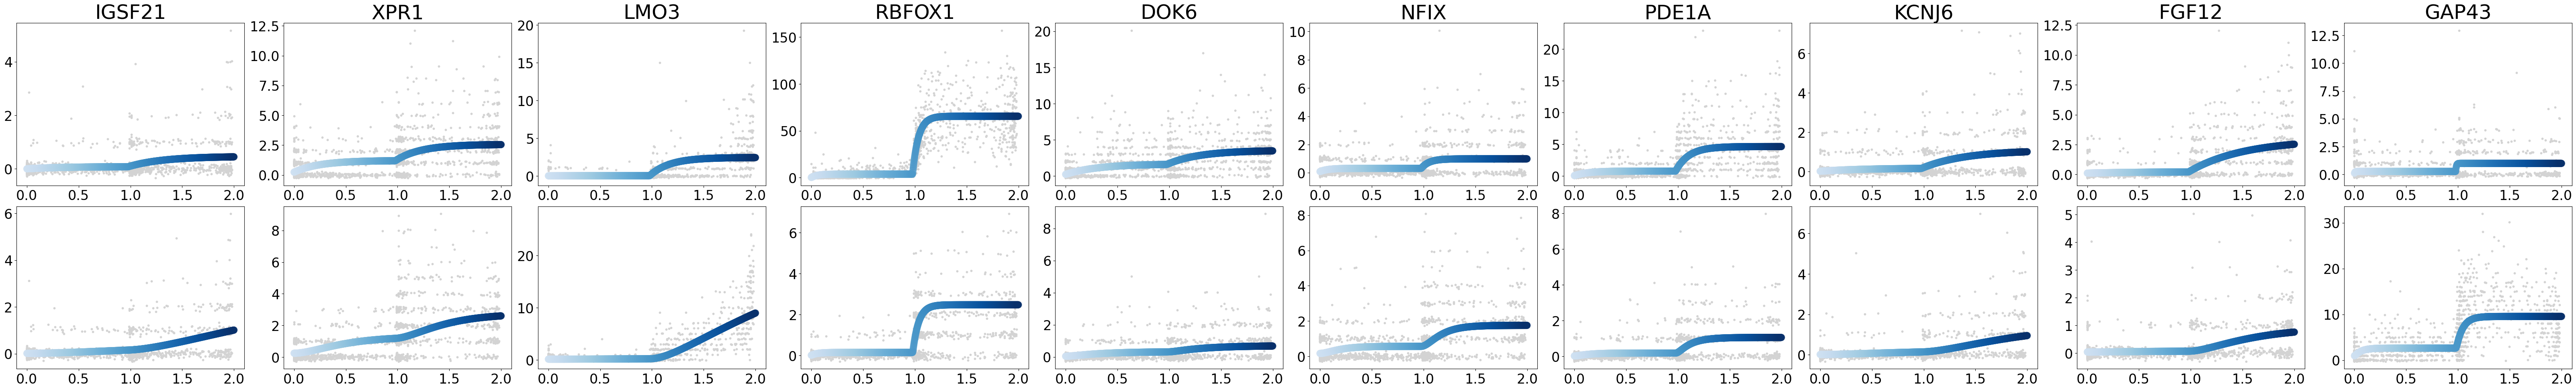

In [68]:
n, p, _ = X.shape
up_mask = (traj.theta[:,2] > 2*traj.theta[:,1]) & (traj.theta[:,1] > 2*traj.theta[:,0])
print(up_mask.sum())
up_idx = np.arange(p)[up_mask]
plot_y(traj,X=X,idx=up_idx[:10],gene_name=fitted_genes);